## Finding the correspondences between fiducial particle positions in EM and LM images

This notebook aims to detect the corespondence between the fiducial particles automatically detected in EM and then LM images. Correspnding particles will be assign the same ID number and saved with the ID number in the .xml file. The .xml file then can be loaded into ec-CLEM software and allow to register the EM and LM images based on the automatically detected correspondences.

Load the necessary python libraries:

In [1]:
import os
import open3d as o3d
import numpy as np
import pandas as pd
from pathlib import Path
import bigfish.stack as stack
import bigfish.plot as plot
from utils import xml_to_dataframe, dataframe_to_xml, dataframe_to_pointcloud, dataframe_to_xml_
from utils import visualize_result_nparray, clean_correspondences, print_transformations, chamfer_distance
from utils import convert_to_pcd, save_correspondences_in2df, save_correspondences_in1df

#### Loading the file with fiducial particles locations 

Load the locations for fiducial particles in EM (target) and LM (source) from the .xml file. The locations were automatically detected using notebooks: 
-   Detect_fiducial_particles_in_EM.ipynb
-   Detect_fiducial_particles_in_LM.ipynb 
and then saved in different formats. For further processing we need to load them, here loading .xml format into pandas dataframe and scale the source points to cover the same region as target image.

In [2]:
"""
# Loading the PLY files

input_folder = 'E:/DATA/AI4Life_Pr26/20240805_Trial_data_fiducial_particles/240723_JB294_CLEM-AI4life_sample1/pos1/'

target_ply = "target_clusters.ply"
target_path_ply = Path(os.path.join(input_folder, "output", target_ply))
print(target_path_ply.exists())

source_ply = "source_clusters.ply"
source_path_ply = Path(os.path.join(input_folder, "output", source_ply))
print(source_path_ply.exists())

# Load the point clouds 
target = o3d.io.read_point_cloud(str(target_path_ply))#(target_path) # ('target.ply') ('target_all.ply')
source_small  = o3d.io.read_point_cloud(str(source_path_ply))#(source_path) # ('source.ply') ('source_all.ply')
"""

'\n# Loading the PLY files\n\ninput_folder = \'E:/DATA/AI4Life_Pr26/20240805_Trial_data_fiducial_particles/240723_JB294_CLEM-AI4life_sample1/pos1/\'\n\ntarget_ply = "target_clusters.ply"\ntarget_path_ply = Path(os.path.join(input_folder, "output", target_ply))\nprint(target_path_ply.exists())\n\nsource_ply = "source_clusters.ply"\nsource_path_ply = Path(os.path.join(input_folder, "output", source_ply))\nprint(source_path_ply.exists())\n\n# Load the point clouds \ntarget = o3d.io.read_point_cloud(str(target_path_ply))#(target_path) # (\'target.ply\') (\'target_all.ply\')\nsource_small  = o3d.io.read_point_cloud(str(source_path_ply))#(source_path) # (\'source.ply\') (\'source_all.ply\')\n'

In [3]:
# Loading the XML files

input_folder = 'E:/DATA/AI4Life_Pr26/20240805_Trial_data_fiducial_particles/240723_JB294_CLEM-AI4life_sample1/pos1/'

# target_xml_clust = "target_clusters.xml"
target_xml_clust = "Ground_truth_fiducials_EM_only_clusters.xml" # Ground truth fiducials
target_path_xml_clust = Path(os.path.join(input_folder, 'output', target_xml_clust))
print(target_path_xml_clust.exists())

# source_xml_clust = 'source_clusters.xml'
source_xml_clust = "Ground_truth_fiducials_LM_only_clusters.xml" # Ground truth fiducials
source_path_xml_clust = Path(os.path.join(input_folder, 'output', source_xml_clust))
print(source_path_xml_clust.exists())

target_df_clust = xml_to_dataframe(target_path_xml_clust)
print(target_df_clust)
source_df_small_clust = xml_to_dataframe(source_path_xml_clust)   # small means it is smaller resolution than target, we need to scale it up
print(source_df_small_clust)

True
True
     id     name        pos_x         pos_y     color
0   307  Point2D  3094.660065   6753.518998 -16711936
1   208  Point2D  5456.646665   3125.733147 -16711936
2   293  Point2D  5204.209821   8585.980894 -16711936
3   227  Point2D   842.124834   9940.988165 -16711936
4   207  Point2D  5151.359878   4346.004525 -16711936
5   284  Point2D  3413.135260  10946.068919 -16711936
6   155  Point2D  5595.811744   1996.145810 -16711936
7   166  Point2D  1950.588448   2072.008438 -16711936
8   151  Point2D  4880.988494   1665.959972 -16711936
9   170  Point2D   822.209144   1704.235684 -16711936
10  213  Point2D    82.280127   7689.546850 -16711936
11  178  Point2D  1145.892614   5184.751410 -16711936
12  138  Point2D  5723.336466   1138.007670 -16711936
13  278  Point2D  5249.491125  13533.328759 -16711936
14  157  Point2D  4690.501448   2259.247538 -16711936
15  182  Point2D  1824.907877   5544.677491 -16711936
16  105  Point2D  3333.249522    497.193511 -16711936
17  239  Point2D  

### Rescaling LM image coordinates for Fiducial Particles to match the EM image coordinate system

EM and LM images have most probably different sizes. LM image is usually much smaller. The points that were detected in LM image coordinate system needs to be rescaled to EM image coordinate system, otherwise it might be very hard with the registration.

In [4]:
def find_the_scale(EM_shape, LM_shape):
    scale_x = EM_shape[0]/LM_shape[0]
    scale_y = EM_shape[1]/LM_shape[1]
    return scale_x, scale_y

# load the EM and LM images
EM_image_path = os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos1_bin4_EM.tif")
LM_image_path  = os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos1_LM.tif")

EMimage = stack.read_image(EM_image_path)
LMimage_small = stack.read_image(LM_image_path)

# Find what is the scaling rate between the 2 images
scale_y, scale_x = find_the_scale(EMimage.shape, LMimage_small.shape)

print("Scale x: ",scale_x) #scale_x = 22.966165413533833
print("Scale y: ",scale_y) 

# Resize the LM point positions
source_df_clust = xml_to_dataframe(source_path_xml_clust)
source_df_clust['pos_x'] = source_df_small_clust['pos_x']*scale_x
source_df_clust['pos_y'] = source_df_small_clust['pos_y']*scale_y


# Resize the LM image to fit the position of the resized points
LMimage = stack.resize_image(LMimage_small, EMimage.shape, method='bilinear')
#EMimage_small = stack.resize_image(EMimage, LMimage_small.shape, method='bilinear')

print(LMimage.shape)

Scale x:  22.966165413533833
Scale y:  24.873456790123456
(16118, 6109, 3)


Plotting the point coordinates on top of the image to double check the correct placement

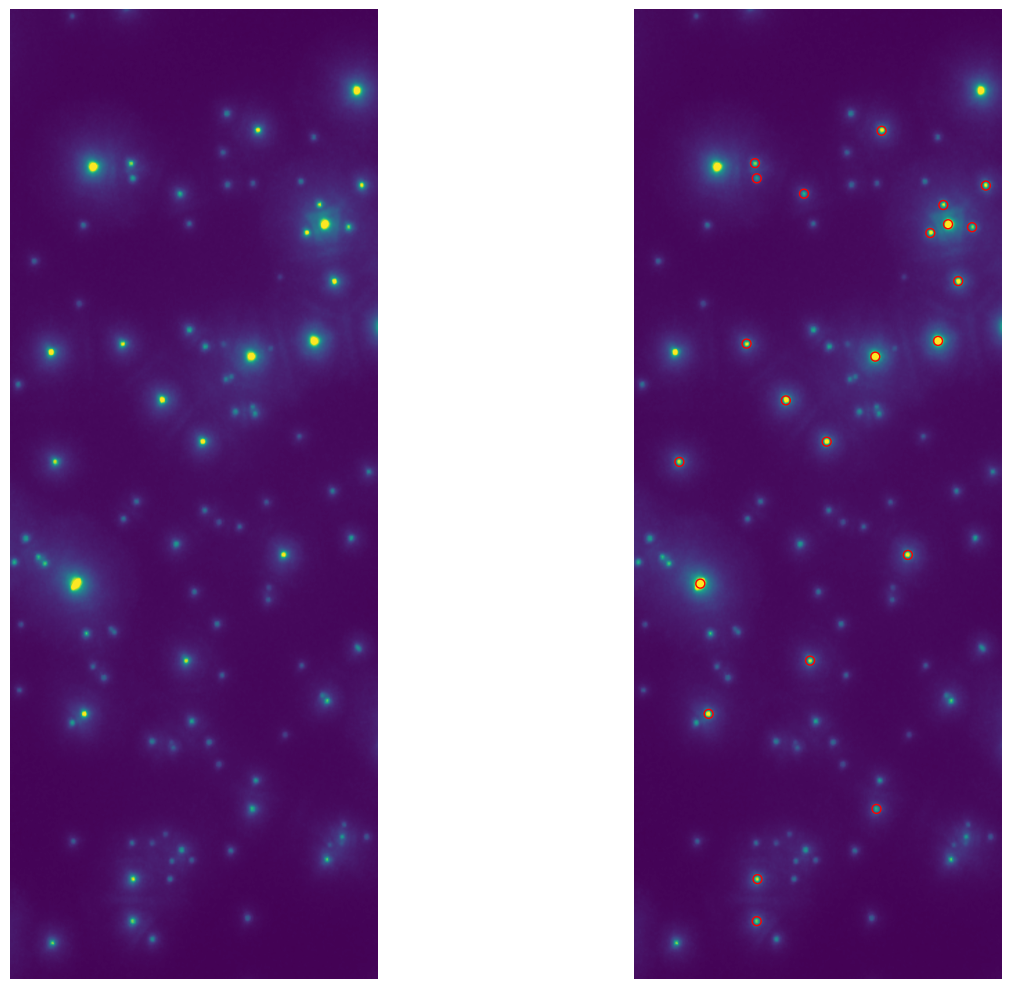

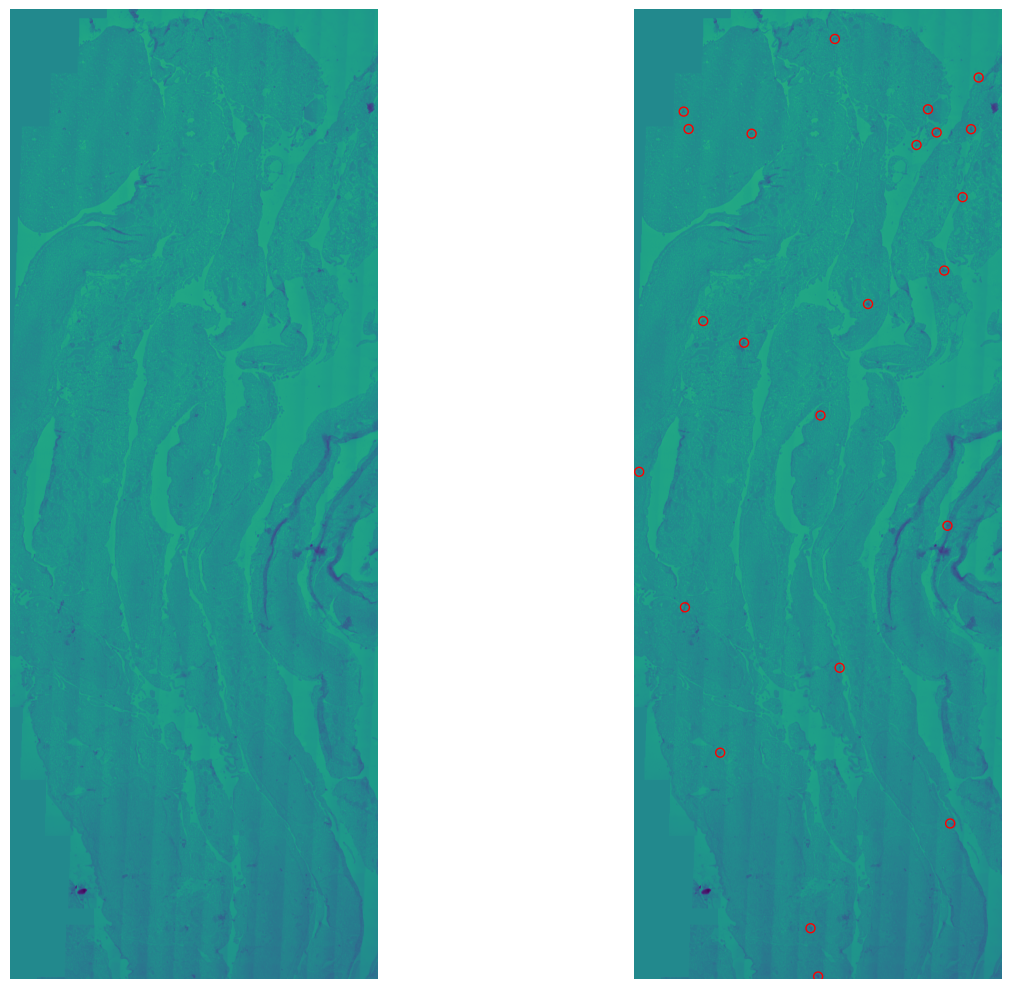

(23, 2)
(23, 2)


In [5]:
#plot.plot_detection(LMimage_small[:,:,1], source_small, contrast=True)
target_clust = target_df_clust[['pos_x', 'pos_y']].to_numpy()
source_clust = source_df_clust[['pos_x', 'pos_y']].to_numpy()

plot.plot_detection(LMimage[:,:,1], (source_clust[:, [1, 0]]), shape="circle", radius = 3*scale_y, color = "red", linewidth = 1, fill=False, contrast=True) 
plot.plot_detection(EMimage, (target_clust[:, [1, 0]]), radius = 3*scale_y, contrast=False)

print(source_clust.shape)
print(target_clust.shape)


Converting points from dataframe into points clouds and saving them as .ply files

In [6]:
target_clusters = dataframe_to_pointcloud(target_df_clust, "target_clusters.ply")  #target_pcd
source_clusters = dataframe_to_pointcloud(source_df_clust, "source_clusters.ply")  #source_pcd

# Visualize the point cloud
#o3d.visualization.draw_geometries([target_clusters])
#o3d.visualization.draw_geometries([source_clusters])

Loading the coordinates for regions of Fiducial particles:

In [7]:
# target_xml_regi = "target_regions.xml"
target_xml_regi = "Ground_truth_fiducials_EM.xml"  # Ground truth fiducial
target_path_xml_regi = Path(os.path.join(input_folder, 'output', target_xml_regi))
print(target_path_xml_regi.exists())

#source_xml_regi = 'source_regions.xml'
source_xml_regi = 'Ground_truth_fiducials_LM.xml' # Ground truth fiducial
source_path_xml_regi = Path(os.path.join(input_folder, 'output', source_xml_regi))
print(source_path_xml_regi.exists())

target_df_regi = xml_to_dataframe(target_path_xml_regi)
print(target_df_regi)
source_df_small_regi = xml_to_dataframe(source_path_xml_regi)   # small means it is smaller resolution than target, we need to scale it up
print(source_df_small_regi)

# Resize the LM point positions
source_df_regi = xml_to_dataframe(source_path_xml_regi)
source_df_regi['pos_x'] = source_df_small_regi['pos_x']*scale_x
source_df_regi['pos_y'] = source_df_small_regi['pos_y']*scale_y

target_regions = dataframe_to_pointcloud(target_df_regi, "target_regions.ply")  #target_pcd
source_regions = dataframe_to_pointcloud(source_df_regi, "source_regions.ply")  #source_pcd

True
True
      id     name        pos_x         pos_y     color
0    211  Point2D  5455.950882   3147.167461 -16711936
1    232  Point2D   837.644606   9968.175774 -16711936
2    227  Point2D   842.124834   9940.988165 -16711936
3    276  Point2D  5259.356397  12974.503801 -16711936
4    156  Point2D  5606.525071   2015.673956 -16711936
..   ...      ...          ...           ...       ...
178  270  Point2D  3394.883738  12703.080864 -16711936
179  174  Point2D   148.590509   4613.513092 -16711936
180  217  Point2D   138.637538   9639.287682 -16711936
181  190  Point2D  3862.804911   4889.703784 -16711936
182  191  Point2D  3859.082162   4916.059028 -16711936

[183 rows x 5 columns]
       id     name       pos_x       pos_y     color
0     763  Point2D  140.962072  225.662265 -16711936
1    1610  Point2D   88.150207  103.408264 -16711936
2    1531  Point2D   48.709341  382.848371 -16711936
3     745  Point2D  149.543768  410.953454 -16711936
4     718  Point2D  159.462540  562.35798

## Testing different registration methods provided by Probreg package

### Test different registration methods:

In [8]:
'''
import numpy as np
from probreg import callbacks
from probreg import cpd, gmmtree, filterreg, bcpd, l2dist_regs


# 1. Coherent Point Drift (CPD) - rigid - WORKS
tf_param_rigid, _, _ = cpd.registration_cpd(source_points, target_points, tf_type_name='rigid', maxiter=1000, tol=1e-5)
result_rigid = tf_param_rigid.transform(source_points)
visualize_result_nparray(source_points, target_points, result_rigid, "Rigid CPD")


# 2. Coherent Point Drift (CPD) - nonrigid - WORKS
tf_param_nonrigid, _, _ = cpd.registration_cpd(source_points, target_points, tf_type_name='nonrigid', maxiter=1000, tol=1e-5)
result_nonrigid = tf_param_nonrigid.transform(source_points)
visualize_result_nparray(source_points, target_points, result_nonrigid, "Non-rigid CPD")
chamfer_distance(target_points, result_nonrigid, "Chamfer distance 1st - Nonrigid CPD")


# 3. Coherent Point Drift (CPD) - affine - ERROR -  LinAlgError: Singular matrix
#tf_param_affine, _, _ = cpd.registration_cpd(source_points, target_points, tf_type_name='affine', maxiter=1000, tol=1e-5)
#result_affine = tf_param_affine.transform(source_points)
#visualize_result_nparray(source_points, target_points, result_affine, "Affine CPD")


# 4. FilterReg - WORKS
tf_param_filterreg, _, _ = filterreg.registration_filterreg(source_points, target_points, objective_type="pt2pt")
result_filterreg = tf_param_filterreg.transform(source_points)
visualize_result_nparray(source_points, target_points, result_filterreg, "FilterReg")


# 5. GMMReg (Gaussian Mixture Model Registration) ERROR - TypeError: cannot unpack non-iterable RigidTransformation object
#tf_param_gmmreg, _ = l2dist_regs.registration_gmmreg(source_points, target_points)
#result_gmmreg = tf_param_gmmreg.transform(source_points)
#visualize_result_nparray(source_points, target_points, result_gmmreg, "GMMReg")


# 6. SVR (Support Vector Registration) ERROR - InvalidParameterError: The 'gamma' parameter of OneClassSVM must be a str among {'scale', 'auto'} or a float in the range [0.0, inf). Got np.float64(inf) instead.
#tf_param_svr = l2dist_regs.registration_svr(source_points, target_points)
#result_svr = tf_param_svr.transform(source_points)
#visualize_result_nparray(source_points, target_points, result_svr, "SVR")


# 7. Bayesian Coherent Point Drift (BCPD) (experimental) - Error: cannot unpack non-iterable CombinedTransformation object
#tf_param_bcpd, _ = bcpd.registration_bcpd(source_points, target_points)
#result_bcpd = tf_param_bcpd.transform(source_points)
#visualize_result_nparray(source_points, target_points, result_bcpd, "BCPD")


# 8. GMMTree (Hierarchical Stochastic Model) - WORKS, but NO TRANSFORMATION
#tf_param_gmmtree, _ = gmmtree.registration_gmmtree(source_points, target_points)
#result_gmmtree = tf_param_gmmtree.transform(source_points)
#visualize_result_nparray(source_points, target_points, result_gmmtree, "GMMTree")
'''

'\nimport numpy as np\nfrom probreg import callbacks\nfrom probreg import cpd, gmmtree, filterreg, bcpd, l2dist_regs\n\n\n# 1. Coherent Point Drift (CPD) - rigid - WORKS\ntf_param_rigid, _, _ = cpd.registration_cpd(source_points, target_points, tf_type_name=\'rigid\', maxiter=1000, tol=1e-5)\nresult_rigid = tf_param_rigid.transform(source_points)\nvisualize_result_nparray(source_points, target_points, result_rigid, "Rigid CPD")\n\n\n# 2. Coherent Point Drift (CPD) - nonrigid - WORKS\ntf_param_nonrigid, _, _ = cpd.registration_cpd(source_points, target_points, tf_type_name=\'nonrigid\', maxiter=1000, tol=1e-5)\nresult_nonrigid = tf_param_nonrigid.transform(source_points)\nvisualize_result_nparray(source_points, target_points, result_nonrigid, "Non-rigid CPD")\nchamfer_distance(target_points, result_nonrigid, "Chamfer distance 1st - Nonrigid CPD")\n\n\n# 3. Coherent Point Drift (CPD) - affine - ERROR -  LinAlgError: Singular matrix\n#tf_param_affine, _, _ = cpd.registration_cpd(source_po

Print transformations:

In [9]:
'''
# 1
print_transformations(tf_param_rigid, "Rigid CPD Transformation:")

# 2
print("Non-rigid CPD Transformation:")
print(tf_param_nonrigid.g)  # Displacement field
print(tf_param_nonrigid.w)  # Weight matrix

# 3
#print("Affine CPD Transformation:")
#print(tf_param_affine.b)  # Affine matrix
#print(tf_param_affine.t)  # Translation vector

#4
print_transformations(tf_param_filterreg, "FilterReg Transformation:")

#5-8
#print_transformations(tf_param_gmmreg, "GMMReg Transformation:")
#print_transformations(tf_param_svr, ""SVR Transformation:"")
#print_transformations(result_bcpd, "BCPD Transformation:")
#print_transformations(tf_param_gmmtree, "GMMTree Transformation:")
'''

'\n# 1\nprint_transformations(tf_param_rigid, "Rigid CPD Transformation:")\n\n# 2\nprint("Non-rigid CPD Transformation:")\nprint(tf_param_nonrigid.g)  # Displacement field\nprint(tf_param_nonrigid.w)  # Weight matrix\n\n# 3\n#print("Affine CPD Transformation:")\n#print(tf_param_affine.b)  # Affine matrix\n#print(tf_param_affine.t)  # Translation vector\n\n#4\nprint_transformations(tf_param_filterreg, "FilterReg Transformation:")\n\n#5-8\n#print_transformations(tf_param_gmmreg, "GMMReg Transformation:")\n#print_transformations(tf_param_svr, ""SVR Transformation:"")\n#print_transformations(result_bcpd, "BCPD Transformation:")\n#print_transformations(tf_param_gmmtree, "GMMTree Transformation:")\n'

### Test multilevel registration methods - first rigid and then non-rigid registration

In [10]:
import numpy as np
import open3d as o3d
from probreg import cpd, gmmtree, filterreg, bcpd, l2dist_regs
scale = 1000
'''
# Load the point clouds and set the scale
source = o3d.io.read_point_cloud("source.ply") # ('source.ply') ('source_all.ply')
target = o3d.io.read_point_cloud("target.ply") # ('target.ply') ('target_all.ply')
source_all = o3d.io.read_point_cloud("source_all.ply") # ('source.ply') ('source_all.ply')
target_all = o3d.io.read_point_cloud("target_all.ply") # ('target.ply') ('target_all.ply')


# Convert to numpy arrays and subscale the points
source_points = np.asarray(source.points)/scale         # Subscale the points, so the physical distance between them is not too large
target_points = np.asarray(target.points)/scale          # Subscale the points, so the physical distance between them is not too large
source_points_all = np.asarray(source_all.points)/scale         # Subscale the points, so the physical distance between them is not too large
target_points_all = np.asarray(target_all.points)/scale          # Subscale the points, so the physical distance between them is not too large

'''
# Convert to numpy arrays and subscale the points
source_points = np.asarray(source_clusters.points)/scale         # Subscale the points, so the physical distance between them is not too large
target_points = np.asarray(target_clusters.points)/scale          # Subscale the points, so the physical distance between them is not too large
source_points_all = np.asarray(source_regions.points)/scale         # Subscale the points, so the physical distance between them is not too large
target_points_all = np.asarray(target_regions.points)/scale          # Subscale the points, so the physical distance between them is not too large

# ------------------------------------------------------------------------------------------
# 1st - registration by Coherent Point Drift (CPD) - rigid
tf_param_rigid, _, _ = cpd.registration_cpd(source_points, target_points, tf_type_name='rigid', maxiter=1000, tol=1e-5)
source_points_res2 = tf_param_rigid.transform(source_points)
source_points_all_res2 = tf_param_rigid.transform(source_points_all)

#visualize_result_nparray(source_points, target_points, source_points_res2, "Rigid CPD")
print_transformations(tf_param_rigid, "Rigid CPD Transformation:")
chamfer_distance(target_points, source_points_res2, "Chamfer distance 1st - Rigid CPD")
chamfer_distance(target_points_all, source_points_all_res2, " all Chamfer distance 2nd - Nonrigid CPD")

# ------------------------------------------------------------------------------------------
# 2nd - registration by Coherent Point Drift (CPD) - nonrigid 
tf_param_nonrigid, _, _ = cpd.registration_cpd(source_points_res2, target_points, tf_type_name='nonrigid', maxiter=1000, tol=1e-5)
source_points_res3 = tf_param_nonrigid.transform(source_points_res2)

tf_param_nonrigid_all, _, _ = cpd.registration_cpd(source_points_all_res2, target_points_all, tf_type_name='nonrigid', maxiter=1000, tol=1e-5)
source_points_all_res3 = tf_param_nonrigid_all.transform(source_points_all_res2)

#visualize_result_nparray(source_points_res2, target_points, source_points_res3, "Nonrigid CPD")

print("Non-rigid CPD Transformation:")
print(tf_param_nonrigid.g)  # Displacement field
print(tf_param_nonrigid.w)  # Weight matrix

chamfer_distance(target_points, source_points_res3, "Chamfer distance 2nd - Nonrigid CPD")
chamfer_distance(target_points_all, source_points_all_res3, "all Chamfer distance 2nd - Nonrigid CPD")

# ------------------------------------------------------------------------------------------
# 3rd - finding the correspondence between the points 
threshold = 0.02
trans_init = np.asarray([[ 1, 0, 0, 0],  # In trying to have identity matrix as initial transformation so I can instead of source point use result of non-rigid reg points and to the ICP on those
                         [ 0, 1, 0, 0],
                         [ 0, 0, 1, 0],
                         [ 0, 0, 0, 1]])

sour = convert_to_pcd(source_points_res3)
targ = convert_to_pcd(target_points)
sour_all = convert_to_pcd(source_points_all_res3)
targ_all = convert_to_pcd(target_points_all)

evaluation = o3d.pipelines.registration.evaluate_registration(sour, targ, threshold, trans_init)
evaluation_all = o3d.pipelines.registration.evaluate_registration(sour_all, targ_all, threshold, trans_init)
print("Evaluation: ", evaluation)
print("Correspondence set: ")
print(np.asarray(evaluation.correspondence_set))

print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    sour, targ, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)

#evaluation = o3d.pipelines.registration.evaluate_registration(sour, targ, threshold, reg_p2p.transformation)
#evaluation_all = o3d.pipelines.registration.evaluate_registration(sour_all, targ_all, threshold, reg_p2p.transformation)
#print("Evaluation: ", evaluation)
print("Correspondence set: ")
print(np.asarray(evaluation_all.correspondence_set))


correspondences = clean_correspondences(np.asarray(evaluation.correspondence_set))
correspondences_all = clean_correspondences(np.asarray(evaluation_all.correspondence_set))
print("Correspondences: ", correspondences_all)

dff2s,dff2t = save_correspondences_in2df(source_points, target_points, correspondences)

# This correspondence seems to be working in a way that corresponding point may repeat in the list. 
# same point can be corresponding to multiple points - fixed by clean_correspondences

#orig_source_df = save_correspondences_in1df(np.asarray(orig_source.points), np.asarray(orig_target.points), correspondences)
orig_source_df, orig_target_df = save_correspondences_in2df((source_points)/[scale_y,scale_x,1]*scale, 
                                                            target_points*scale, correspondences)

orig_source_all_df, orig_target_all_df = save_correspondences_in2df((source_points_all)/[scale_y,scale_x,1]*scale, 
                                                            target_points_all*scale, correspondences_all)

df = save_correspondences_in1df(source_points_all, target_points_all, correspondences_all)

Rigid CPD Transformation:
[[ 0.99023235  0.139427    0.        ]
 [-0.139427    0.99023235  0.        ]
 [ 0.          0.          1.        ]]
[-1.83947014 -1.26949281  0.        ]
1.1891505455854638
Chamfer distance = 0.04878192412196851 (Chamfer distance 1st - Rigid CPD) 
Chamfer distance = 0.03526129258317882 ( all Chamfer distance 2nd - Nonrigid CPD) 
Non-rigid CPD Transformation:
[[1.00000000e+00 2.08923761e-02 1.49463369e-02 9.78387613e-21
  1.25126348e-07 5.69517322e-10 2.96061075e-23 8.08335841e-02
  1.02752290e-06 7.22186685e-01 3.77504766e-01 3.93619090e-02
  4.55531590e-02 7.85829067e-01 2.35542981e-03 1.95996356e-04
  1.38867455e-12 5.68446554e-02 1.81093201e-01 4.66176495e-02
  1.48512349e-01 5.38903901e-17 1.20555632e-01]
 [2.08923761e-02 1.00000000e+00 7.38991722e-02 2.17445013e-14
  1.27666426e-05 9.37926507e-06 2.15566709e-16 2.79343668e-02
  1.04721216e-02 1.73961301e-03 9.83423833e-03 7.58933052e-02
  6.64908409e-01 3.06361308e-03 1.10738769e-01 3.50153481e-04
  7.4

Finding correspondences using Point2Point algorithm - This one can be applied to full set of points

Create panda dataframe with the corresponding points having the same "id":

In [11]:
dataframe_to_xml(orig_source_df, 'original_source_points_2205.xml')
dataframe_to_xml(orig_target_df, 'original_target_points_2205.xml')
dataframe_to_xml(orig_source_all_df, 'original_source_points_all_2205.xml')
dataframe_to_xml(orig_target_all_df, 'original_target_points_all_2205.xml')

In [12]:
orig_source_df

id       name       pos_x       pos_y
0    1  'Point2D'  128.530587  312.982157
1    2  'Point2D'  216.375233  196.811262
2    3  'Point2D'  182.765107  394.928794
3    4  'Point2D'   44.103239  415.742020
4    5  'Point2D'  202.907060  240.092323
5    6  'Point2D'  117.434421  471.432640
6    7  'Point2D'  225.662241  157.840890
7    8  'Point2D'  113.373868  133.587821
8    9  'Point2D'  206.444968  141.773776
9   10  'Point2D'   80.648219  111.468325
10  11  'Point2D'   30.152624  327.655917
11  12  'Point2D'   75.019729  242.051727
12  13  'Point2D'  234.868842  127.709609
13  14  'Point2D'  161.819084  578.720904
14  15  'Point2D'  197.761013  162.064495
15  16  'Point2D'  101.272614  283.155672
16  17  'Point2D'  165.196178   88.042560
17  18  'Point2D'   49.651322  509.967589
18  19  'Point2D'   82.336766  629.534785
19  20  'Point2D'   81.814121  659.927320
20  21  'Point2D'   81.814121  122.440989
21  22  'Point2D'  161.015014  251.500409
22  23  'Point2D'  209.580841  155.707317

In [13]:
orig_target_all_df

id       name   pos_x    pos_y
0      1  'Point2D'  5455.0   3147.0
1      2  'Point2D'   837.0   9968.0
2      3  'Point2D'   842.0   9940.0
3      4  'Point2D'  5259.0  12974.0
4      5  'Point2D'  5606.0   2015.0
..   ...        ...     ...      ...
154  155  'Point2D'  3394.0  12703.0
155  156  'Point2D'   148.0   4613.0
156  157  'Point2D'   138.0   9639.0
157  158  'Point2D'  3862.0   4889.0
158  159  'Point2D'  3859.0   4916.0

[159 rows x 4 columns]

In [14]:
orig_source_all_df

id       name       pos_x       pos_y
0      1  'Point2D'  216.415436  197.290228
1      2  'Point2D'   43.419779  416.787036
2      3  'Point2D'   44.022832  416.264528
3      4  'Point2D'  163.869463  558.081846
4      5  'Point2D'  226.144683  158.015060
..   ...        ...         ...         ...
154  155  'Point2D'  109.031890  534.307743
155  156  'Point2D'   46.274228  213.270257
156  157  'Point2D'   23.318030  401.198887
157  158  'Point2D'  161.216032  250.368309
158  159  'Point2D'  161.015014  251.500409

[159 rows x 4 columns]

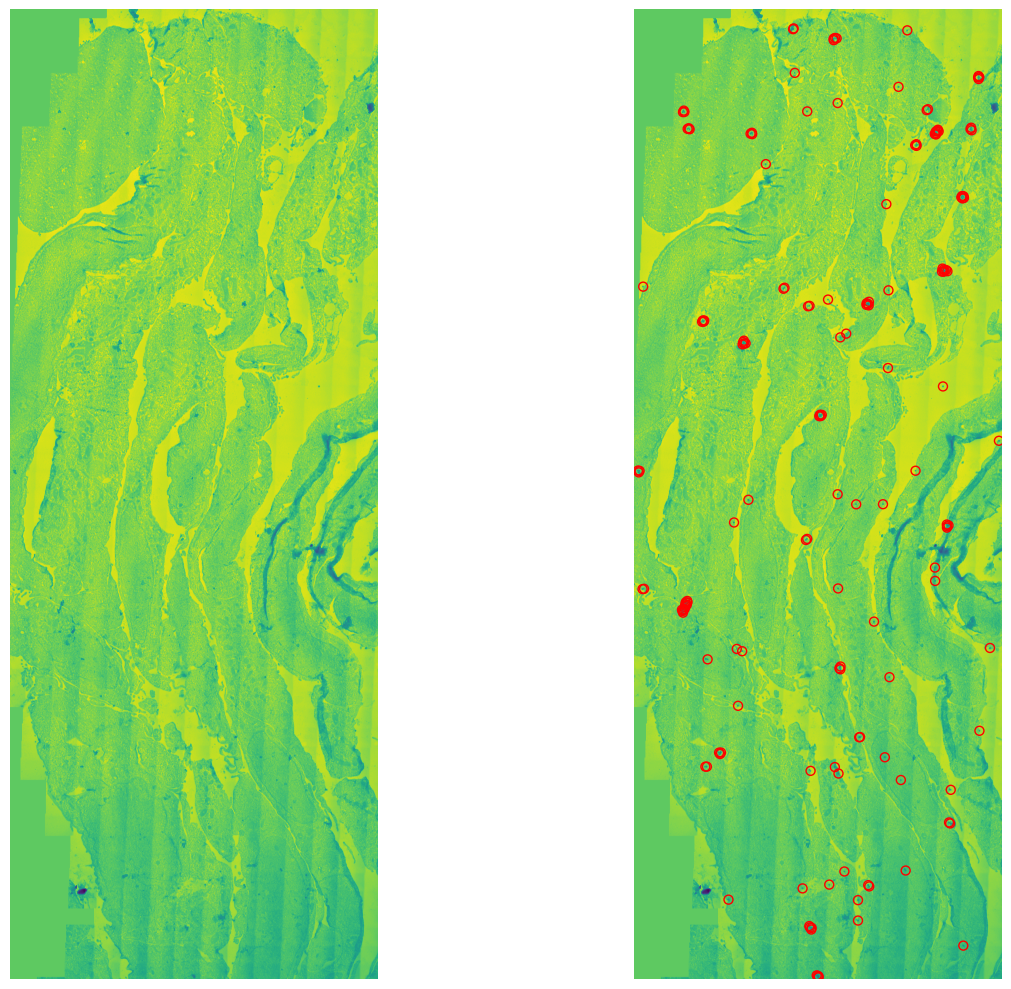

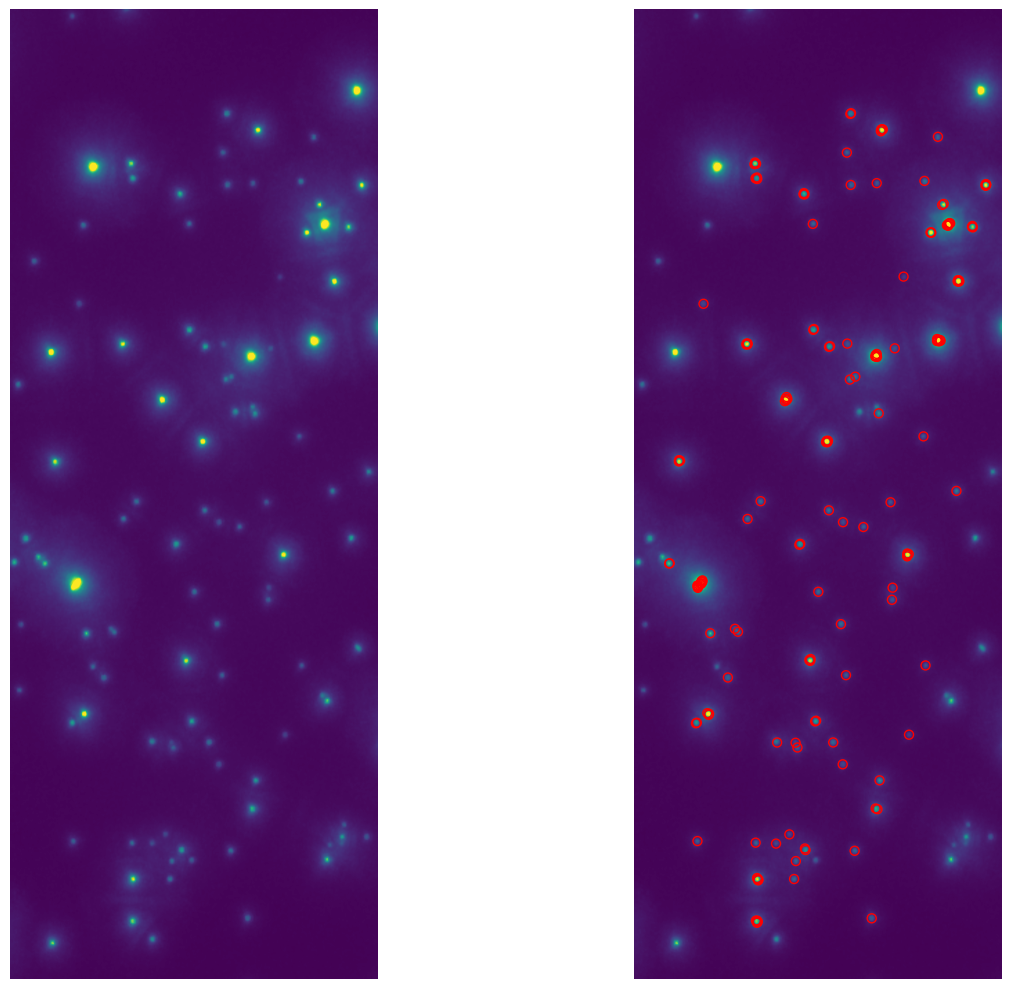

In [15]:
source_database = orig_source_all_df
target_database = orig_target_all_df

pointsT = np.column_stack((target_database['pos_y'], target_database['pos_x'])) #np.column_stack((target_database['pos_y'], target_database['pos_x']))
#pointsT_swapped = [[x, y] for y, x in pointsT]
plot.plot_detection(EMimage, pointsT, shape="circle", radius = 3*scale_y, color = "red", linewidth = 1, fill=False, contrast=True) 

pointsS = np.column_stack((source_database['pos_y']*scale_x, source_database['pos_x']*scale_y)) #np.column_stack((target_database['pos_y'], target_database['pos_x']))
#pointsT_swapped = [[x, y] for y, x in pointsT]
plot.plot_detection(LMimage[:,:,1], pointsS, shape="circle", radius = 3*scale_y, color = "red", linewidth = 1, fill=False, contrast=True) 

### To warp an image according to a displacement field calculated from point clouds.
Expand the displacement field to cover the convex hull and then the entire image.

To start understanding the displacement field I produce the field myself from vector between the corresponding pairs and use it.

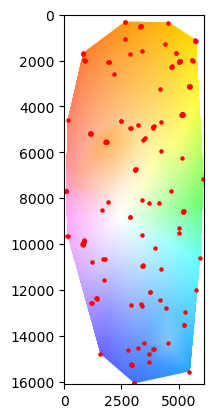

In [16]:
import numpy as np
import flow_vis
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


def expand_displacement_field(points, displacements, image_shape):
    # Create a grid covering the entire image
    y, x = np.mgrid[0:image_shape[0], 0:image_shape[1]]   # y, x = np.mgrid[0:image_shape[0], 0:image_shape[1]]

    # Interpolate
    expanded_field = griddata(points, displacements, (y, x), method='linear', fill_value=0)  #
 
 #   # Interpolate x and y displacements separately
 #   dx = griddata(points, displacements[:, 0] * weights, (y, x), method='linear', fill_value=0)
 #   dy = griddata(points, displacements[:, 1] * weights, (y, x), method='linear', fill_value=0)
 #   
 #   # Stack the two displacement fields
 #   expanded_field = np.stack([dx, dy], axis=-1)
    return expanded_field

def calculate_displacement_vectors(source_database, target_database):
    displacements_x = np.asarray((np.asarray(source_database['pos_x']*scale_y) - target_database['pos_x']))
    displacements_y = np.asarray((np.asarray(source_database['pos_y']*scale_x) - target_database['pos_y']))
    displacements = np.column_stack((displacements_x, displacements_y))
    return displacements

def visualize_extended_field(expanded_field, point_cloud):
    flow_color = flow_vis.flow_to_color(expanded_field, convert_to_bgr=False)
    plt.imshow(flow_color)
    plt.scatter(point_cloud[:, 0], point_cloud[:, 1], c='r', s=5)     # plt.scatter(point_cloud[:, 1], point_cloud[:, 0], c='r', s=5)
    plt.show()


source_database = orig_source_all_df
target_database = orig_target_all_df
points = np.column_stack((target_database['pos_x'], target_database['pos_y']))  #points = np.column_stack((source_database['pos_x']*scale_x, source_database['pos_y']*scale_y))

displacements = calculate_displacement_vectors(source_database, target_database)

points_swapped = [[x, y] for y, x in points]  # here I am swapping the x and y coordinates
expanded_field = expand_displacement_field(points_swapped, displacements, EMimage.shape)

visualize_extended_field(expanded_field, points)

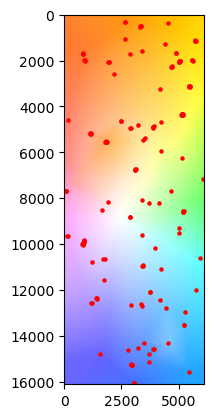

In [17]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from scipy.ndimage import distance_transform_edt

def extrapolate_displacement_field(expanded_field):
    H, W, _ = expanded_field.shape

    # Identify valid (non-zero) displacement vectors
    # This assumes [0, 0] is only used outside the convex hull
    known_mask = np.any(expanded_field != 0, axis=-1)

    # Initialize output with the original field
    extrapolated_field = expanded_field.copy()

    # Use distance transform to get the nearest known value for each pixel
    distance, indices = distance_transform_edt(~known_mask, return_indices=True)

    # Fill zero values with the displacement from the nearest known pixel
    for i in range(2):  # for x and y components
        channel = expanded_field[..., i]
        filled = channel[indices[0], indices[1]]
        extrapolated_field[..., i] = np.where(known_mask, channel, filled)

    return extrapolated_field


ef = extrapolate_displacement_field(expanded_field)
visualize_extended_field(ef, points)

In [18]:
'''from scipy.ndimage import map_coordinates

def warp_image_ndimage(image, displacement_field):
    height, width = image.shape[:2]
    y_coords, x_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    map_y = y_coords + displacement_field[:,:,1]
    map_x = x_coords + displacement_field[:,:,0]
    coords = [map_y.ravel(), map_x.ravel()]
    warped = map_coordinates(image, coords, order=1, mode='constant', cval=0)
    return warped.reshape(image.shape).astype(image.dtype)

warped_image = warp_image_ndimage(LMimage.astype(np.float16), ef.astype(np.float16))
'''

"from scipy.ndimage import map_coordinates\n\ndef warp_image_ndimage(image, displacement_field):\n    height, width = image.shape[:2]\n    y_coords, x_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')\n    map_y = y_coords + displacement_field[:,:,1]\n    map_x = x_coords + displacement_field[:,:,0]\n    coords = [map_y.ravel(), map_x.ravel()]\n    warped = map_coordinates(image, coords, order=1, mode='constant', cval=0)\n    return warped.reshape(image.shape).astype(image.dtype)\n\nwarped_image = warp_image_ndimage(LMimage.astype(np.float16), ef.astype(np.float16))\n"

In [25]:
from scipy.interpolate import interpn

def warp_image(image, displacement_field):
    height, width = image.shape[:2]
    y_coords, x_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    
    src_coords = np.stack([
        y_coords + displacement_field[:,:,1], 
        x_coords + displacement_field[:,:,0]
    ], axis=-1)
    
    warped_image = interpn(
        (np.arange(height), np.arange(width)),
        image,
        src_coords,
        method='linear',
        bounds_error=False,
        fill_value=0
    )
    
    return warped_image.astype(image.dtype)

warped_image1 = warp_image(LMimage[:,:,1], ef.astype(np.float16))
#mask = np.any(expanded_field == 0, axis=-1)
#warped_image[mask] = 0
#plt.imshow(warped_image[:,:,0])
#plt.show()

In [20]:
#import cv2
#cv2.imwrite((str(input_folder)+'/fiducial_detection3.png'), warped_image)

In [21]:
##import tifffile

# arr_3d is your 3D NumPy array
#tifffile.imwrite('output_image.tif', warped_image)

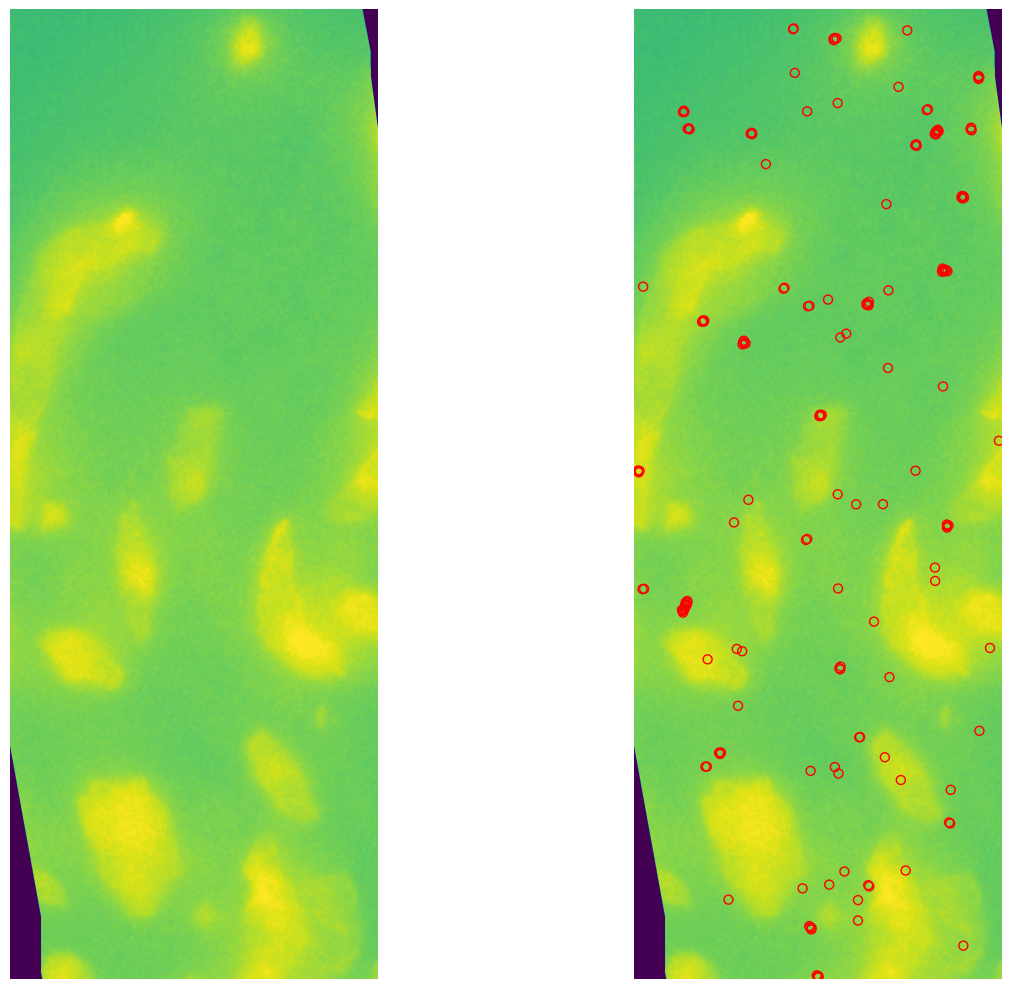

In [23]:
target_database = orig_target_all_df
pointsT = np.column_stack((target_database['pos_y'], target_database['pos_x'])) #np.column_stack((target_database['pos_y'], target_database['pos_x']))
#pointsT_swapped = [[x, y] for y, x in pointsT]
plot.plot_detection(warped_image, pointsT, shape="circle", radius = 3*scale_y, color = "red", linewidth = 1, fill=False, contrast=True) 


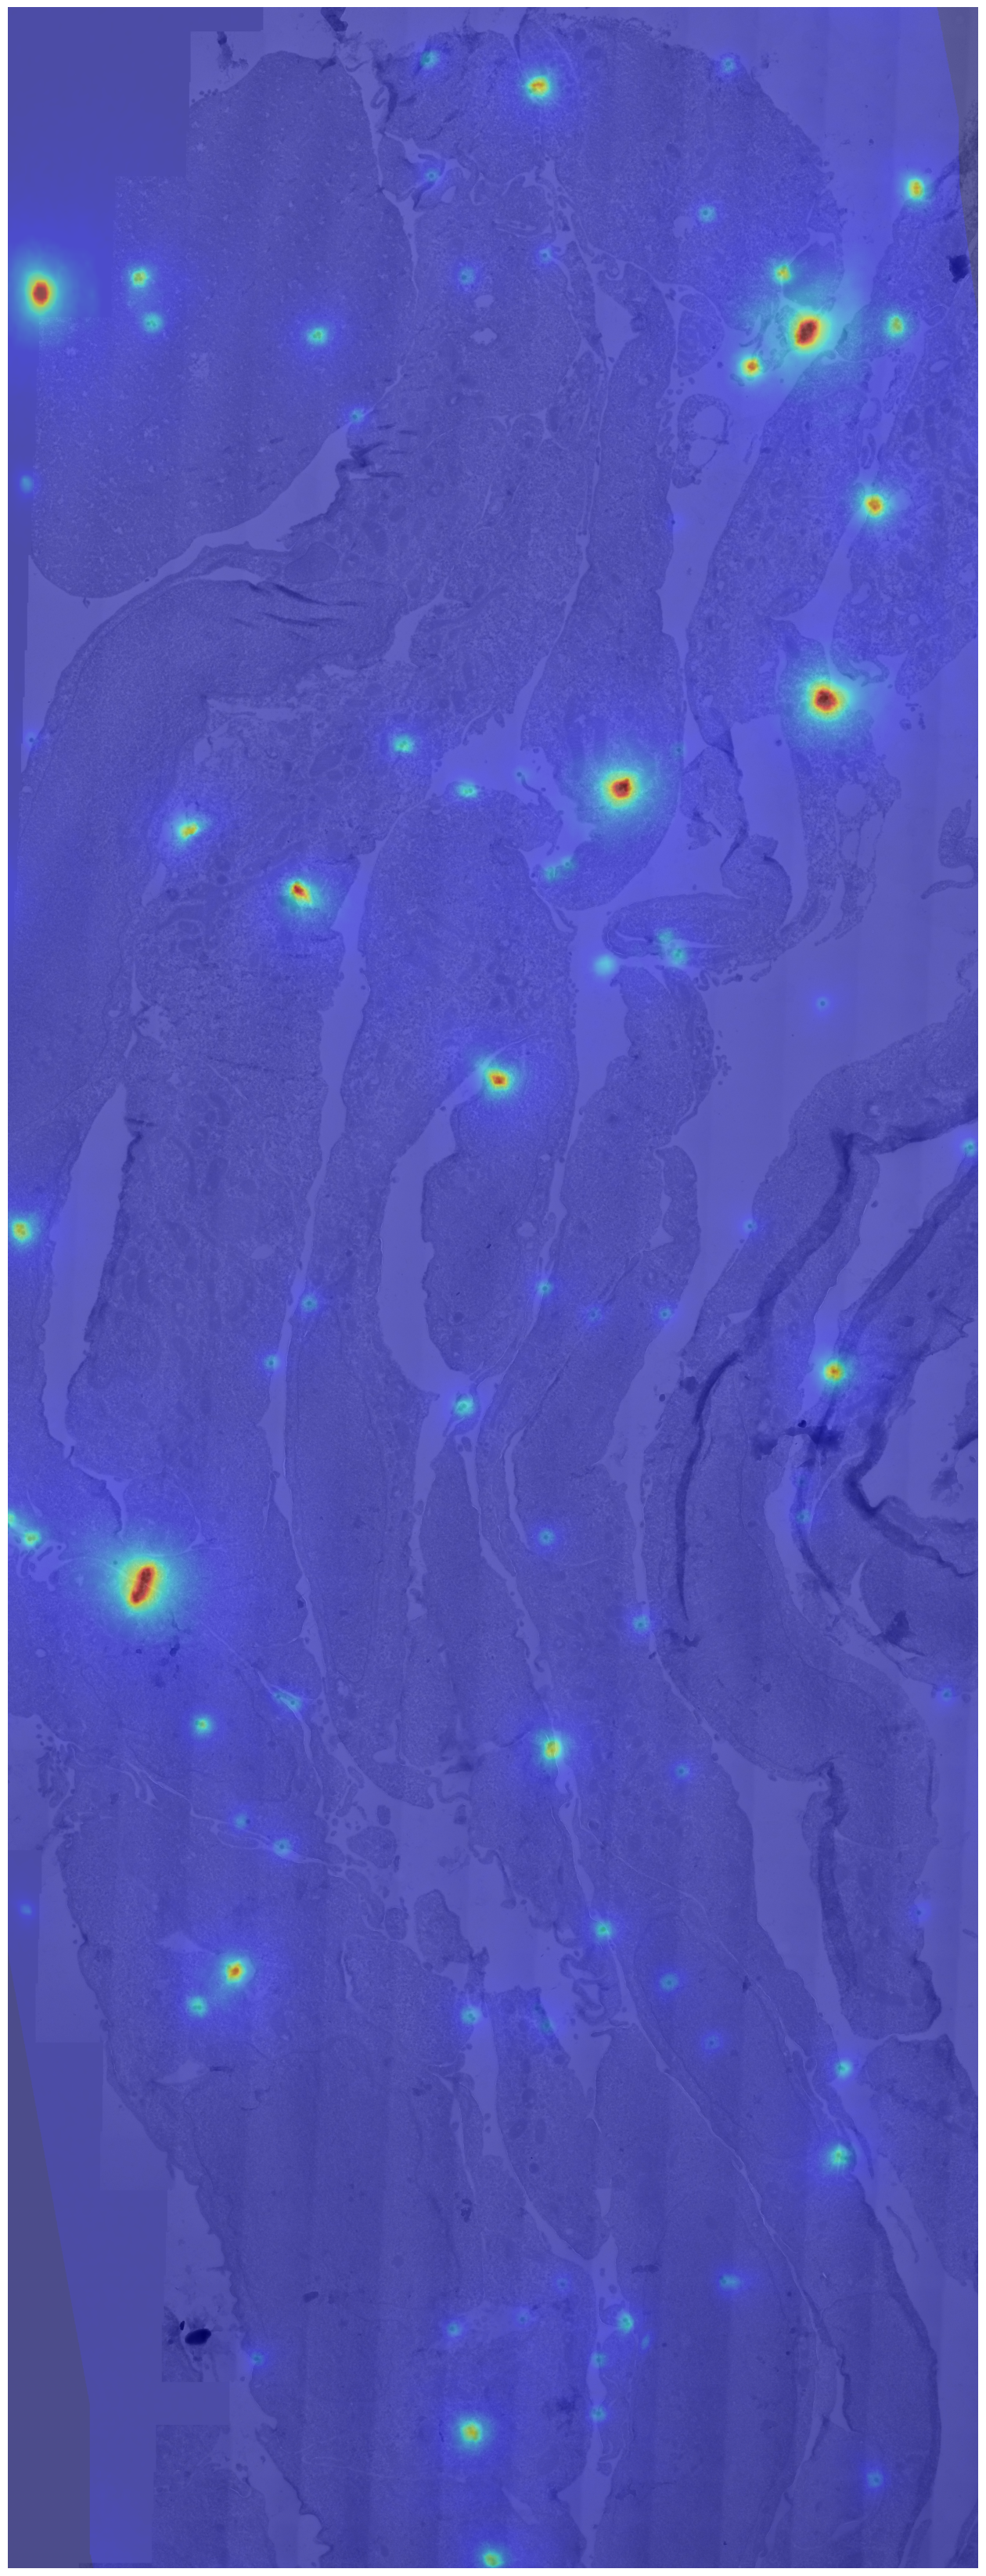

In [27]:
import matplotlib.pyplot as plt

# img1 and img2 are your 2D or 3D NumPy arrays (e.g., grayscale or RGB images)
plt.figure(figsize=(16, 53))
plt.imshow(EMimage, cmap='gray')              # Base image (e.g., grayscale)
plt.imshow(warped_image1, alpha=0.5, cmap='jet')    # Overlay with 50% transparency; adjust cmap as needed

plt.axis('off')
plt.savefig('overlap1b.png', dpi=300, bbox_inches='tight', transparent=True)  # 
plt.show()
#cv2.imwrite((str(input_folder)+'/fiducial_detection3.png'), warped_image)

In [ ]:
'''
from scipy.interpolate import interpn

def warp_image(image, displacement_field):
    height, width = image.shape[:2]
    y_coords, x_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    
    src_coords = np.stack([
        y_coords + displacement_field[:,:,1], 
        x_coords + displacement_field[:,:,0]
    ], axis=-1)
    
    warped_image = interpn(
        (np.arange(height), np.arange(width)),
        image,
        src_coords,
        method='linear',
        bounds_error=False,
        fill_value=0
    )
    
    return warped_image.astype(image.dtype)

warped_image = warp_image(EMimage, expanded_field)
plt.imshow(warped_image)
plt.show()

pointsT = np.column_stack((target_database['pos_x'], target_database['pos_y']))
pointsT_swapped = [[x, y] for y, x in pointsT]
plot.plot_detection(warped_image, np.array(pointsT_swapped) , shape="circle", radius = 3*scale_y, color = "red", linewidth = 1, fill=False, contrast=True) 
'''

In [ ]:
warped_image[:,:,0].shape

In [ ]:
height, width = EMimage.shape[:2]
y_coords, x_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
src_coords = np.stack([
    y_coords - expanded_field[:,:,1],
    x_coords - expanded_field[:,:,0]
    ], axis=-1)
#print(src_coords)

src_coords[8000:8010,3000]

In [ ]:


# Load point cloud data
orig_source = o3d.io.read_point_cloud("source.ply") #("source_all.ply")
orig_target = o3d.io.read_point_cloud("target.ply") #("target_all.ply")
orig_source_all = o3d.io.read_point_cloud("source_all.ply")
orig_target_all = o3d.io.read_point_cloud("target_all.ply")

correspondences = clean_correspondences(np.asarray(evaluation.correspondence_set))
correspondences_all = clean_correspondences(np.asarray(evaluation_all.correspondence_set))

# Upscale back the coordinates
source_points = np.asarray(source.points)*scale
target_points = np.asarray(target.points)*scale

result_df = save_correspondences_in1df(source_points, target_points, correspondences)
#result_source_df,result_target_df = save_correspondences_in2df(source_points, target_points, correspondences)
print(result_df)
#print (result_target_df)

result_all_df = save_correspondences_in1df(source_points_all, target_points_all, correspondences_all)
##############################


#orig_source_df = save_correspondences_in1df(np.asarray(orig_source.points), np.asarray(orig_target.points), correspondences)
orig_source_df, orig_target_df = save_correspondences_in2df(np.asarray(orig_source.points)/[scale_y,scale_x,1], 
                                                            np.asarray(orig_target.points), correspondences)

orig_source_all_df, orig_target_all_df = save_correspondences_in2df(np.asarray(orig_source_all.points)/[scale_y,scale_x,1], 
                                                            np.asarray(orig_target_all.points), correspondences_all)

print(orig_source_df)
print(orig_target_df)
print(orig_source_all_df)
print(orig_target_all_df)

In [ ]:
# after registration of source to target using cpd algorithm I want to detect the corresponding points in the source and target point clouds
# and then calculate the distance between the corresponding points in the source and target point clouds.

# I want to write the corresponding points in the source and target point clouds to a .txt file called "corresponding_points.txt"
# and the distances between the corresponding points in the source and target point clouds to a .txt file called "distances.txt"

# Convert Open3D point clouds to NumPy arrays
source_points = np.asarray(source.points)
target_points = np.asarray(target.points)
result_points = np.asarray(result.points)

# Find the corresponding points in the source and target point clouds
correspondence = cpd.registration_cpd.find_correspondence(source_points, target_points, tf_param.rot, tf_param.t)

# Write the corresponding points to a .txt file
np.savetxt("corresponding_points.txt", correspondence, fmt='%f', delimiter=' ')

# Calculate the distances between the corresponding points in the source and target point clouds
distances = np.linalg.norm(source_points[correspondence[:, 0]] - target_points[correspondence[:, 1]], axis=1)

# Write the distances to a .txt file
np.savetxt("distances.txt", distances, fmt='%f', delimiter=' ')

# Print the average distance
print("Average distance:", np.mean(distances))

# I want to write the transformation matrix to a .txt file called "transformation_matrix.txt"
# and the transformed source point cloud to a .ply file called "result.ply"

# Write the transformation matrix to a .txt file
np.savetxt("transformation_matrix.txt", tf_param.rot, fmt='%f', delimiter=' ')


In [ ]:
# after registration of source to target using cpd algorithm I want to detect the points in the source that are not in the target
# I want to write the coordinates of these points to a .txt file called "source_not_in_target.txt"

# Convert Open3D PointCloud to NumPy array
source_points = np.asarray(source.points)
target_points = np.asarray(target.points)
result_points = np.asarray(result.points)

# Find the points in the source that are not in the target
source_not_in_target = np.setdiff1d(source_points, target_points, assume_unique=False)
print(source_not_in_target)

# Write the coordinates of these points to a .txt file
np.savetxt("source_not_in_target.txt", source_not_in_target, fmt='%f', delimiter=' ')


In [ ]:
import numpy as np
import transforms3d as t3d
from probreg import filterreg
from probreg import callbacks
import utils


cbs = [callbacks.Open3dVisualizerCallback(source, target)]
tf_param, _, _ = filterreg.registration_filterreg(source, target,
                                                  objective_type='pt2pt',
                                                  sigma2=None,
                                                  update_sigma2=True,
                                                  callbacks=cbs)

result = copy.deepcopy(source)
result.points = tf_param.transform(result.points)

print("result: ", np.rad2deg(t3d.euler.mat2euler(tf_param.rot)),
      tf_param.scale, tf_param.t)
print("result: ", tf_param.rot,
      tf_param.scale, tf_param.t)
# draw result
source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0, 1])
o3.visualization.draw_geometries([source, target, result])

TODO:

- I was checking different registration methods
Need to do: clean detection of fiducial particles in EM to get only the large clusters 3+ particles
- take only the strongest points from LM image. 
- alternatively we can subsample the points first and use only a subset - hard subsample the same way both EM and LM detections
- method for detecting registration pair and assign the same ID number to the both particles


In [ ]:
from probreg import cpd
from probreg import callbacks
import matplotlib.pyplot as plt
import utils

def prepare_source_and_target_nonrigid_2d(source_filename,
                                          target_filename):
    source = np.loadtxt(source_filename)
    target = np.loadtxt(target_filename)
    return source, target

print(source)
print(target)

source, target = prepare_source_and_target_nonrigid_2d('source_2D.txt',
                                                             'target_2D.txt')
cbs = [callbacks.Plot2DCallback(source, target)]
tf_param, _, _ = cpd.registration_cpd(source, target, 'affine',
                                      callbacks=cbs)
plt.show()

In [ ]:
from probreg import cpd
from probreg import callbacks
import matplotlib.pyplot as plt
import utils

source, target = prepare_source_and_target_nonrigid_2d('source_2D.txt',
                                                             'target_2D.txt')
cbs = [callbacks.Plot2DCallback(source, target)]
tf_param, _, _ = cpd.registration_cpd(source, target, 'nonrigid',
                                      callbacks=cbs)
plt.show()